# On the claims of the fast weights paper

Use fast weights to aid in learning associative tasks and store temporary memories of recent past. In a traditional recurrent architecture we have our slow weights which are used to determine the next hidden state and hold long-term memory. We introduce the concept of fast weights, in conjunction with the slow weights, in order to account for short-term knowledge. These weights are quick to update and decay as they change from the introduction of new hidden states.

They extend the standard vanilla recurrent neural network architecture with some form of Hebbian short-term synaptic plasticity. This Hebbian connectivity maintains a dynamically changing short-term memory of the recent history of the activities of the units in the network. They call this Hebbian connectivity “fast weights” as opposed to the standard “slow” recurrent connectivity.

We don't store memories by keeping track of the exact neural activity that occurred at the time of the memory. Instead, we try to recreate the neural activity through a set of associative weights which can map to many other memories as well. This allows for efficient storage of many memories without storing separate weights for each instance. This associative network also allows for associative learning which is the ability to learn the recall the relationship between initially unrelated instances.

## Concept
* In a traditional recurrent architecture we have our slow weights. These weights are used with the input and the previous hidden state to determine the next hidden state. These weights are responsible for the long-term knowledge of our systems. These weights are updated at the end of a batch, so they are quite slow to update and decay.

* They introduce the concept of fast weights, in conjunction with the slow weights, in order to account for short-term knowledge. These weights are quick to update and decay as they change from the introduction of new hidden states.


The equation governing the model can be condensed into the following form (The inner loop of Hebbian plasticity is unrolled for one step only, i.e. S=1 as done in the paper)

$$
\mathbf{h}_{t+1} = f\left(\mathcal{LN}\left[\mathbf{W}_h \mathbf{h}_{t} + \mathbf{W}_x \mathbf{x}_{t} + (\eta \sum_{\tau=1}^{\tau=t-1} \lambda^{t - \tau -1} f(\mathbf{W}_h \mathbf{h}_{t} +  \mathbf{W}_x \mathbf{x}_{t})\right]\right)
$$

In [75]:
import os
import glob
import numpy as np
import pandas as pd
import itertools
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [6]:
replications = sorted(glob.glob('replication_*/'))
print(replications)
all_exps = []
for rep in replications:
    temp_exp = sorted(glob.glob(os.path.join(rep, 'exps/*/*_testinglog.npy')))
    print(len(temp_exp))
    all_exps.append(temp_exp)

['replication_1/', 'replication_2/', 'replication_3/']
10
10
10


In [3]:
# exp_file = np.load('replication_1/exps/exp_0_0_1_1/exp_0_0_1_1_testinglog.npy', allow_pickle=True)[0]
# ce = exp_file['CrossEntropy']
# max_val = np.array(ce).max()
# max_id = np.argmax(ce)

In [24]:
exp_arr = np.zeros((3, 10, 2, 200))
for rep in range(len(replications)):
    labels = []
    for e, exp in enumerate(all_exps[rep]):
        exp_file = np.load(exp, allow_pickle=True)[0]
        length_ce = len(exp_file['CrossEntropy'])
        length_acc = len(exp_file['Accuracy'])
        assert length_acc == length_ce
        if length_ce > 200:
            length = 200
        else:
            length = length_ce
        exp_arr[rep, e, 0, :length] = exp_file['CrossEntropy'][:length]
        exp_arr[rep, e, 1, :length] = exp_file['Accuracy'][:length]
        # parse exp name
        exp_name = exp.split('/')[-2]
#         if exp_name == 'exp_0_0_1_1':
#             ce[max_id] = 0.5*(ce[max_id-1] + ce[max_id+1])
        exp_parms = [int(f) for f in exp_name.split('_')[1:]]
        label = 'RNN-'
        if exp_parms[0] == 1:
            label += 'CTRL-'
        else:
            label += 'FW-'
        if exp_parms[1] == 1:
            label += 'LN-'
        if exp_parms[2] == 1:
            label += 'DEPTH-'
        if exp_parms[3] == 0:
            label += 'HS=64'
        else:
            label += 'HS=128'
        labels.append(label)
exp_arr = np.transpose(exp_arr, (1, 0, 2, 3))
print(len(labels))

10


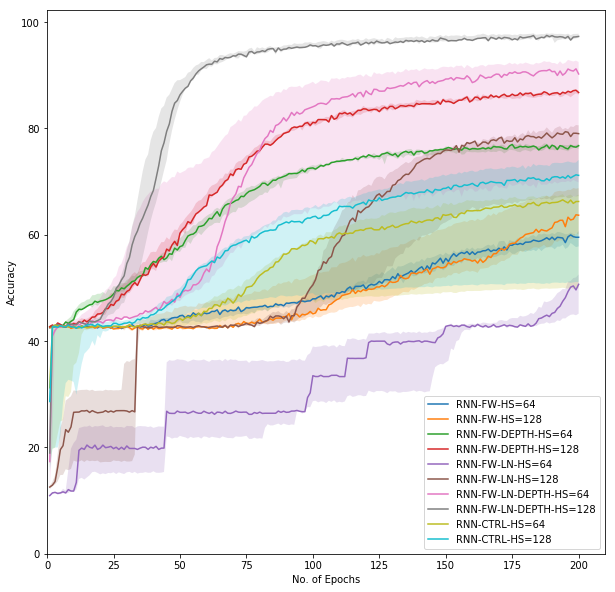

In [31]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
fig2, ax2 = plt.subplots(figsize=(10, 10))
for l, label in enumerate(labels):
    df_acc = pd.DataFrame(exp_arr[l, :, 1, :].T, columns=replications)
    for col in replications:
        df_acc[col] = df_acc[col].replace(0, np.nan).ffill()
    df_acc['median'] = df_acc.quantile(0.5, axis=1)
    df_acc['1_quartil'] = df_acc.quantile(0.10, axis=1)
    df_acc['3_quartil'] = df_acc.quantile(0.90, axis=1)
#     print(df_acc.head())
#     assert 2 == 1
    df_ce = pd.DataFrame(exp_arr[l, :, 0, :].T, columns=replications)
    for col in replications:
        df_ce[col] = df_ce[col].replace(0, np.nan).ffill()
    df_ce['median'] = df_ce.median(axis=1)
    df_ce['1_quartil'] = df_ce.quantile(0.10, axis=1)
    df_ce['3_quartil'] = df_ce.quantile(0.90, axis=1)
    
    ax1.fill_between(
        np.arange(1, 201),
        df_acc['1_quartil'].values,
        df_acc['3_quartil'].values,
        alpha=0.2
    )
    ax1.plot(np.arange(1, 201), df_acc['median'].values, label=label)

    ax2.fill_between(
        np.arange(1, 201),
        df_ce['1_quartil'].values,
        df_ce['3_quartil'].values,
        alpha=0.2
    )
    ax2.plot(np.arange(1, 201), df_ce['median'].values, label=label)
ax1.set_xlabel('No. of Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax1.legend(frameon=True)
fig1.savefig('acc.svg', bbox_inches='tight')
ax2.set_xlabel('No. of Epochs')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)
ax2.legend(frameon=True)
fig2.savefig('ce.svg', bbox_inches='tight')
plt.close()

In [33]:
ctrl_acc = 0
for rep in range(len(replications)):
    # RNN-CTRL-HS=64
    ctrl_1 = np.load(
        f'replication_{rep+1}/exps/exp_1_0_0_1/exp_1_0_0_1_testinglog.npy',
        allow_pickle=True)[0]
    ctrl_1_best_acc = np.array(ctrl_1['Accuracy'][:200]).max()
    # RNN-CTRL-HS=128
    ctrl_2 = np.load(
        f'replication_{rep+1}/exps/exp_1_0_0_0/exp_1_0_0_0_testinglog.npy',
        allow_pickle=True)[0]
    ctrl_2_best_acc = np.array(ctrl_2['Accuracy'][:200]).max()
    ctrl_acc += (1 / len(replications)) * 0.5 * (ctrl_1_best_acc + ctrl_2_best_acc)
print(ctrl_acc)

61.41770833333334


In [67]:
results = list(itertools.product([-1,1],[-1,1],[-1,1]))
results = [list(e) for e in results]
print(results)

[[-1, -1, -1], [-1, -1, 1], [-1, 1, -1], [-1, 1, 1], [1, -1, -1], [1, -1, 1], [1, 1, -1], [1, 1, 1]]


In [68]:
for rep in replications:
    for i, enc_inp in enumerate(results):
        enc_inp = np.array(enc_inp).astype(int)
        enc_inp[enc_inp==-1] = 0
        exp_name = f'exp_0_{enc_inp[0]}_{enc_inp[1]}_{enc_inp[2]}'
        name = f'{rep}/exps/{exp_name}/{exp_name}_testinglog.npy'
        exp_file = np.load(name, allow_pickle=True)[0]
        exp_acc =  np.array(exp_file['Accuracy'][:200]).max()
#         exp_acc = np.log(exp_acc / ctrl_acc)
        exp_acc = exp_acc / ctrl_acc
        results[i].append(exp_acc)
print(results)

[[-1, -1, -1, 1.0008310578178796, 0.9764590152812875, 0.9412493003850001], [-1, -1, 1, 1.038126897440681, 1.1835450552059834, 0.9575312494699885], [-1, 1, -1, 1.2640898220857855, 1.2580349722698054, 1.2423127151846134], [-1, 1, 1, 1.4209562253014703, 1.4224317769372974, 1.406149827852309], [1, -1, -1, 0.8251386509726767, 0.8756635742270313, 0.7041434168348569], [1, -1, 1, 1.2926341140754056, 1.329828191516426, 1.0130934007225114], [1, 1, -1, 1.0021030850901442, 1.4850663998236122, 1.5310629059887042], [1, 1, 1, 1.6013296925086073, 1.578992893607639, 1.5873882736045861]]


In [69]:
labels = [
    'LN',
    'DE',
    'HS'
]
rep_cols = []
for rep in range(len(replications)):
    rep_cols.append(f'rep_{rep}')
col_names = labels + rep_cols
results_df = pd.DataFrame(results, columns=col_names)
results_df['y_avg'] = results_df[rep_cols].mean(axis=1)
err_df = results_df[rep_cols].values - np.repeat(results_df['y_avg'].values, 3).reshape(8, 3)
print(results_df)
print(err_df)

   LN  DE  HS     rep_0     rep_1     rep_2     y_avg
0  -1  -1  -1  1.000831  0.976459  0.941249  0.972846
1  -1  -1   1  1.038127  1.183545  0.957531  1.059734
2  -1   1  -1  1.264090  1.258035  1.242313  1.254813
3  -1   1   1  1.420956  1.422432  1.406150  1.416513
4   1  -1  -1  0.825139  0.875664  0.704143  0.801649
5   1  -1   1  1.292634  1.329828  1.013093  1.211852
6   1   1  -1  1.002103  1.485066  1.531063  1.339411
7   1   1   1  1.601330  1.578993  1.587388  1.589237
[[ 0.0279846   0.00361256 -0.03159716]
 [-0.0216075   0.12381065 -0.10220315]
 [ 0.00927732  0.00322247 -0.01249979]
 [ 0.00444362  0.00591917 -0.01036278]
 [ 0.0234901   0.07401503 -0.09750513]
 [ 0.08078221  0.11797629 -0.1987585 ]
 [-0.33730771  0.1456556   0.19165211]
 [ 0.01209274 -0.01024406 -0.00184868]]


### One way effects

In [70]:
effects = {}
for key in labels:
    eff = results_df.groupby(key)['y_avg'].mean()
    effects[key] = sum([i*eff[i] for i in [-1,1]])
print(effects)

{'LN': 0.05956055697834173, 'DE': 0.3884728888587372, 'HS': 0.22715439019012584}


### Two way effects

In [71]:
twoway_labels = list(itertools.combinations(labels, 2))
for key in twoway_labels:
    eff = results_df.groupby(list(key))['y_avg'].mean()
    effects['-'.join(key)] = sum([i*j*eff[i][j]/2 for i in [-1,1] for j in [-1,1]])
print(effects)

{'LN': 0.05956055697834173, 'DE': 0.3884728888587372, 'HS': 0.22715439019012584, 'LN-DE': 0.06910076152032685, 'LN-HS': 0.10286036532623266, 'DE-HS': -0.021391258628585152}


### Three way effects

In [72]:
threeway_labels = list(itertools.combinations(labels, 3))
for key in threeway_labels: 
    eff = results_df.groupby(list(key))['y_avg'].mean()
    effects['-'.join(key)] = sum([i*j*k*eff[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1]])
print(effects)

{'LN': 0.05956055697834173, 'DE': 0.3884728888587372, 'HS': 0.22715439019012584, 'LN-DE': 0.06910076152032685, 'LN-HS': 0.10286036532623266, 'DE-HS': -0.021391258628585152, 'LN-DE-HS': -0.05879734061498276}


### Fraction of variation explained

In [73]:
SST = 4 * len(replications) * sum([value**2 for key, value in effects.items()])
print(SST)
SST += (err_df **2).sum()
print(SST)
sigma = (err_df **2).sum() / (8 * 2)
print(sigma)
s_q_i = np.sqrt(sigma / (8 * 3))
t_95_16 = 1.7459
print(s_q_i)

2.7039317461837857
2.979846171498194
0.01724465158215053
0.0268053567268983


In [46]:
I = results_df['y_avg'].mean()
print(I)

0.16236048990371632


### Results

In [74]:
row_names = ['I'] + list(effects.keys()) + ['e']
effects_ = np.zeros(len(list(effects.keys())) + 2)
variations = np.zeros(len(list(effects.keys())) + 2)
lower = np.zeros(len(list(effects.keys())) + 2)
upper = np.zeros(len(list(effects.keys())) + 2)
effects_[0] = I
effects_[1:-1] = np.array(list(effects.values()))
variations[1:-1] = 4 * len(replications)*  ((effects_[1:-1]**2 ) / SST) * 100
variations[-1] = ((err_df **2).sum() / SST) * 100
lower = effects_ - t_95_16 * s_q_i
lower[-1] = 0
upper = effects_ + t_95_16 * s_q_i
upper[-1] = 0
arr = np.array([effects_, variations, lower, upper]).T
experiment_df = pd.DataFrame(arr, columns=['effects', '%var', 'lower_CI', 'upper_CI'], index=row_names)
print(experiment_df)

           effects       %var  lower_CI  upper_CI
I         0.162360   0.000000  0.115561  0.209160
LN        0.059561   1.428581  0.012761  0.106360
DE        0.388473  60.772742  0.341673  0.435272
HS        0.227154  20.779241  0.180355  0.273954
LN-DE     0.069101   1.922884  0.022301  0.115900
LN-HS     0.102860   4.260725  0.056061  0.149660
DE-HS    -0.021391   0.184272 -0.068191  0.025408
LN-DE-HS -0.058797   1.392204 -0.105597 -0.011998
e         0.000000   9.259351  0.000000  0.000000


In [82]:
# import matplotlib
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)
z = np.linspace(0,1,50)

Z = np.outer(z.T, z)        # 50x50
X, Y = np.meshgrid(x, y)    # 50x50

color_dimension = 0.162360 + 0.059561*X + 0.3884*Y + 0.227154*Z + \
    0.069101*X*Y + 0.102860*X*Z - 0.021391*Y*Z -0.05879*X*Y*Z
color_dimension /= 2
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)
ax.set_xlabel('LN')
ax.set_ylabel('DE')
ax.set_zlabel('HS')
plt.show()
# fig.savefig('surface.svg', bbox_inches='tight')

ImportError: Failed to import any qt binding